# Imports

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf # TensorFlow and tf.keras
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


In [2]:
train = pd.read_csv('../input/digit-recognizer/train.csv')
test = pd.read_csv('../input/digit-recognizer/test.csv')

# Data preprocessing

In [3]:
train.shape

(42000, 785)

In [4]:
test.shape

(28000, 784)

In [5]:
X = train.drop(columns=['label'])
y = train['label']

In [6]:
'''plt.figure()
plt.imshow(X[1])
plt.colorbar()
plt.grid(False)
plt.show()'''

'plt.figure()\nplt.imshow(X[1])\nplt.colorbar()\nplt.grid(False)\nplt.show()'

In [7]:
X = X / 255.0
test = test / 255.0

In [8]:
X = X.values.reshape(-1, 28, 28, 1)
test = test.values.reshape(-1, 28, 28, 1)

In [9]:
y = tf.keras.utils.to_categorical(y)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
X_train.shape

(33600, 28, 28, 1)

In [12]:
X_test.shape

(8400, 28, 28, 1)

# Model

In [13]:
model = keras.Sequential([
    layers.InputLayer(input_shape=[28, 28, 1]),
    
    preprocessing.RandomRotation(factor=0.10),
    preprocessing.RandomContrast(0.5),
    
    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters=32, kernel_size=(4,4), activation='relu', padding='same', input_shape=[28, 28, 1]),
    layers.MaxPool2D(),

    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'),
    layers.MaxPool2D(),

    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same'),
    layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same'),
    layers.MaxPool2D(),

    layers.Flatten(),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(10, activation='softmax'),
])

In [14]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
random_rotation (RandomRotat (None, 28, 28, 1)         0         
_________________________________________________________________
random_contrast (RandomContr (None, 28, 28, 1)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 1)         7         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 32)        544       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 32)        224       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        1

In [16]:
early_stopping = keras.callbacks.EarlyStopping(
    patience=12,
    min_delta=0.001,
    restore_best_weights=True,
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=200,
    callbacks=[early_stopping],
)

Epoch 1/200
1050/1050 [==============================] - 61s 55ms/step - loss: 0.2216 - accuracy: 0.9313 - val_loss: 0.0616 - val_accuracy: 0.9800
Epoch 2/200
1050/1050 [==============================] - 57s 55ms/step - loss: 0.0991 - accuracy: 0.9691 - val_loss: 0.0562 - val_accuracy: 0.9824
Epoch 3/200
1050/1050 [==============================] - 56s 54ms/step - loss: 0.0856 - accuracy: 0.9742 - val_loss: 0.0618 - val_accuracy: 0.9785
Epoch 4/200
1050/1050 [==============================] - 59s 56ms/step - loss: 0.0721 - accuracy: 0.9769 - val_loss: 0.0369 - val_accuracy: 0.9875
Epoch 5/200
1050/1050 [==============================] - 58s 55ms/step - loss: 0.0684 - accuracy: 0.9785 - val_loss: 0.0485 - val_accuracy: 0.9851
Epoch 6/200
1050/1050 [==============================] - 60s 57ms/step - loss: 0.0663 - accuracy: 0.9809 - val_loss: 0.0406 - val_accuracy: 0.9883
Epoch 7/200
1050/1050 [==============================] - 58s 55ms/step - loss: 0.0578 - accuracy: 0.9819 - val_loss: 0

<AxesSubplot:>

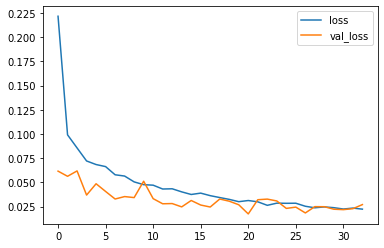

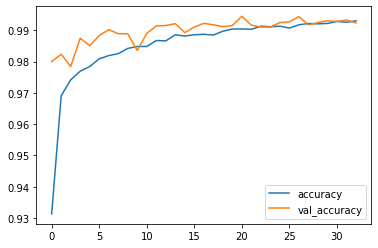

In [17]:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot()

In [18]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)

print('\nTest accuracy:', test_acc)

263/263 - 4s - loss: 0.0174 - accuracy: 0.9945

Test accuracy: 0.994523823261261


# Predictions

In [19]:
predictions = model.predict(test, batch_size=64)

In [20]:
predicted_labels = []

for predictions_array in predictions:
    predicted_labels.append(np.argmax(predictions_array))


# Submission

In [21]:
df = pd.DataFrame()
df['Label'] = predicted_labels
df.reset_index(inplace=True)

In [22]:
df

,index,Label
0,0,2
1,1,0
2,2,9
3,3,0
4,4,3
...,...,...
27995,27995,9
27996,27996,7
27997,27997,3
27998,27998,9


In [23]:
df.rename(columns = {'index':'ImageId'}, inplace=True)
df['ImageId'] = df['ImageId'].apply(lambda x: x+1)

In [24]:
df.to_csv('submission.csv', index=False)